# Neural Network for CLA Project

### Import statements

In [1]:
from sklearn import preprocessing
from sklearn import model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import errno
import os
import sys
import Constants

### Hyperparameters

In [2]:
# data processing
sample_bias = 0     # adjust the difference in the number of the two types of samples (no algae vs algae)
test_size = 0.2
batch_size = 100    # batch size for the DataLoaders

# NN model
num_features = 17
input_size = num_features     # size of input layer
multiplier = 6                # multiplied by num_features to determine the size of each hidden layer
hidden_size = multiplier * input_size
output_size = 1
learning_rate = 0.001         # learning rate of optimizer
num_epochs = 3                # number of epochs

### Read in data

In [3]:
np.set_printoptions(threshold=np.inf)  # prints a full matrix rather than an abbreviated matrix

# define data and destination paths
dest_path = "/Users/Alliot/Documents/CLA-Project/Data/all-data-no-na/neural-network/"
data_path = "/Users/Alliot/Documents/CLA-Project/Data/data-sets/"
data_set = "data_2017_summer"

# if dest_path does not exist, create it
if not os.path.exists(dest_path):
    try:
        os.makedirs(dest_path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

# load data sets
X = np.load(data_path + data_set + ".npy")
y = np.load(data_path + data_set + "_labels.npy")

# manipulate data set. labels are converted to -1, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: -1 for no algae and 1 for algae
for i in range(0, len(y)):
    if y[i] == 0:
        num_no_alg += 1
    if y[i] == 1 or y[i] == 2:
        y[i] = 1
        num_alg += 1

# undersample (shrink) the data set by randomly removing occurences of no algae until the number of no algae samples 
# equals the number of algae samples minus the sample_bias
idx = 0  # index for the data set
while num_no_alg != (num_alg - sample_bias):
    # circle through the data set until the difference of num_no_alg and num_alg equals
    # the value specified by sample_bias
    if idx == (len(y) - 1):
        idx = 0
        
    if y[idx] == 0:
        if np.random.rand() >= 0.5:  # remove this sample with some probability
            y = np.delete(y, obj=idx)
            X = np.delete(X, obj=idx, axis=Constants.ROWS)
            num_no_alg -= 1
        else:
            idx += 1
    else:
        idx += 1

### Process and split data set

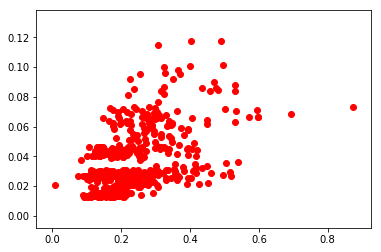

In [19]:
# standardize data: remove the mean and variance in each sample

# TEST DATA DELETE THIS
num_test_samples = 47000
# X = 100*np.random.rand(num_test_samples, num_features)
# y = np.random.randint(2, size=num_test_samples);
# X1 = np.random.randn(1000, num_features)
# X2 = np.random.randn(1000, num_features) + 1.5
# X = np.concatenate((X1, X2), axis=0)
# y1 = np.zeros(shape=(1000, 1))
# y2 = np.ones(shape=(1000, 1))
# y = np.concatenate((y1, y2), axis=0)
# plt.scatter(X1[:, 0], X1[:, 1], color='b')
# plt.scatter(X2[:, 0], X2[:, 1], color='r')





num_splits = 2   # do not change
sss = model_selection.StratifiedShuffleSplit(n_splits=num_splits, test_size=test_size)

idx, _ = sss.split(X, y);
train_idx = idx[0]
test_idx = idx[1]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train = preprocessing.scale(X_train, axis=1, with_mean=False, with_std=True)  # NOTE: MEAN NOT REMOVED
X_test = preprocessing.scale(X_test, axis=1, with_mean=False, with_std=True)

# convert numpy arrays to pytorch tensors
X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

# convert pytorch tensors to pytorch TensorDataset
train_set = utils.TensorDataset(X_train, y_train)
test_set = utils.TensorDataset(X_test, y_test)

# create DataLoaders
train_loader = utils.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = utils.DataLoader(test_set, batch_size=batch_size, shuffle=True)



# plt.scatter(X_train[:, 0], X_train[:, 1], color='b')
plt.scatter(X_train[:, 0], X_train[:, 1], color='r')

### Define neural network model

In [27]:
class CLANet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CLANet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)   # change to hidden_size
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.relu3 = nn.ReLU()
#         self.fc4 = nn.Linear(hidden_size, hidden_size)
#         self.relu4 = nn.ReLU()
#         self.fc5 = nn.Linear(hidden_size, hidden_size)
#         self.relu5 = nn.ReLU()
#         self.fc6 = nn.Linear(hidden_size, hidden_size)
#         self.relu6 = nn.ReLU()
#         self.fc7 = nn.Linear(hidden_size, hidden_size)
#         self.relu7 = nn.ReLU()
#         self.fc8 = nn.Linear(hidden_size, hidden_size)
#         self.relu8 = nn.ReLU()
#         self.fc9 = nn.Linear(hidden_size, hidden_size)
#         self.relu9 = nn.ReLU()
#         self.fc10 = nn.Linear(hidden_size, hidden_size)
#         self.relu10 = nn.ReLU()
#         self.fc11 = nn.Linear(hidden_size, hidden_size)
#         self.relu11 = nn.ReLU()
#         self.fc12 = nn.Linear(hidden_size, output_size)
        self.sig1 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
#         out = self.relu2(out)
#         out = self.fc3(out)
#         out = self.relu3(out)
#         out = self.fc4(out)
#         out = self.relu4(out)
#         out = self.fc5(out)
#         out = self.relu5(out)
#         out = self.fc6(out)
#         out = self.relu6(out)
#         out = self.fc7(out)
#         out = self.relu7(out)
#         out = self.fc8(out)
#         out = self.relu8(out)
#         out = self.fc9(out)
#         out = self.relu9(out)
#         out = self.fc10(out)
#         out = self.relu10(out)
#         out = self.fc11(out)
#         out = self.relu11(out)
#         out = self.fc12(out)
        out = self.sig1(out)
        return out

### Instantiate the neural network

In [28]:
model = CLANet(input_size, hidden_size, output_size)
criterion = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)
model.double();     # cast model parameters to double

### Train the neural network

In [29]:
model.train()     # training mode
training_loss = []

for epoch in range(num_epochs):
    print("Epoch: %d/%d" % (epoch+1, num_epochs))

    for i, (samples, labels) in enumerate(train_loader):
        samples = Variable(samples)
        labels = Variable(labels)
        output = model(samples)                # forward pass
#         output = torch.round(output)           # convert output to binary labels
        output = torch.flatten(output)         # resize predicted labels
        labels = labels.type(torch.DoubleTensor)
        
        loss = criterion(output, labels)  # calculate loss
        optimizer.zero_grad()     # clear gradient
        loss.backward()           # calculate gradients
        optimizer.step()          # update weights

#         for name, param in model.named_parameters():
#             if param.requires_grad:
#                 print(name, param.data)
        
        # calculate and print error
#         error = 1 - torch.sum(output == labels).item() / labels.size()[0]
        training_loss.append(loss.data.numpy())
#         print("  Iteration: %d/%d, Error: %0.4f, Loss: %g" % 
#               (i+1, np.ceil(X_train.size()[0] / batch_size).astype(int), error, loss.item()))
        print("  Iteration: %d/%d, Loss: %g" % 
              (i+1, np.ceil(X_train.size()[0] / batch_size).astype(int), loss.item()))

Epoch: 1/3
  Iteration: 1/5, Loss: 0.710293
  Iteration: 2/5, Loss: 0.725135
  Iteration: 3/5, Loss: 0.709056
  Iteration: 4/5, Loss: 0.691431
  Iteration: 5/5, Loss: 0.722747
Epoch: 2/3
  Iteration: 1/5, Loss: 0.711162
  Iteration: 2/5, Loss: 0.699591
  Iteration: 3/5, Loss: 0.716268
  Iteration: 4/5, Loss: 0.718103
  Iteration: 5/5, Loss: 0.704675
Epoch: 3/3
  Iteration: 1/5, Loss: 0.715381
  Iteration: 2/5, Loss: 0.706723
  Iteration: 3/5, Loss: 0.701867
  Iteration: 4/5, Loss: 0.718303
  Iteration: 5/5, Loss: 0.703417


In [31]:
output
# labels

tensor([0.5651, 0.4217, 0.5056, 0.4863, 0.4689, 0.5068, 0.4969, 0.5839, 0.4692,
        0.4738, 0.4483, 0.4236, 0.4821, 0.6159, 0.4411, 0.4333, 0.4352, 0.4497,
        0.6174, 0.5014, 0.4872, 0.5299, 0.4976, 0.4231, 0.5256, 0.4303, 0.4931,
        0.5357, 0.5272, 0.4344, 0.4318, 0.5881, 0.4470, 0.4411, 0.6083, 0.4328,
        0.6110, 0.4920, 0.5073, 0.6131, 0.5346, 0.5923, 0.4965, 0.4315, 0.4535,
        0.5971, 0.4373, 0.4736, 0.6083, 0.4957, 0.4792, 0.4321, 0.5426, 0.6186,
        0.4205, 0.5516, 0.4329, 0.6083, 0.5887, 0.5526, 0.4393, 0.4609, 0.4285,
        0.4541, 0.4235, 0.4334, 0.6061, 0.5413, 0.4482, 0.4958],
       dtype=torch.float64, grad_fn=<AsStridedBackward>)